## Import Libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from scipy.stats import pointbiserialr
from tabulate import tabulate
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Load Dataset and Check For Missing Values


Missing Values:
+-----------+---------------+
|  Column   | Missing Count |
+-----------+---------------+
|    job    |      39       |
|  marital  |      11       |
| education |      167      |
|  default  |      803      |
|  housing  |      105      |
|   loan    |      105      |
+-----------+---------------+

Percentage of Missing Values:
+-----------+--------------------+
|  Column   | Missing Percentage |
+-----------+--------------------+
|    job    |       0.95%        |
|  marital  |       0.27%        |
| education |       4.05%        |
|  default  |       19.50%       |
|  housing  |       2.55%        |
|   loan    |       2.55%        |
+-----------+--------------------+


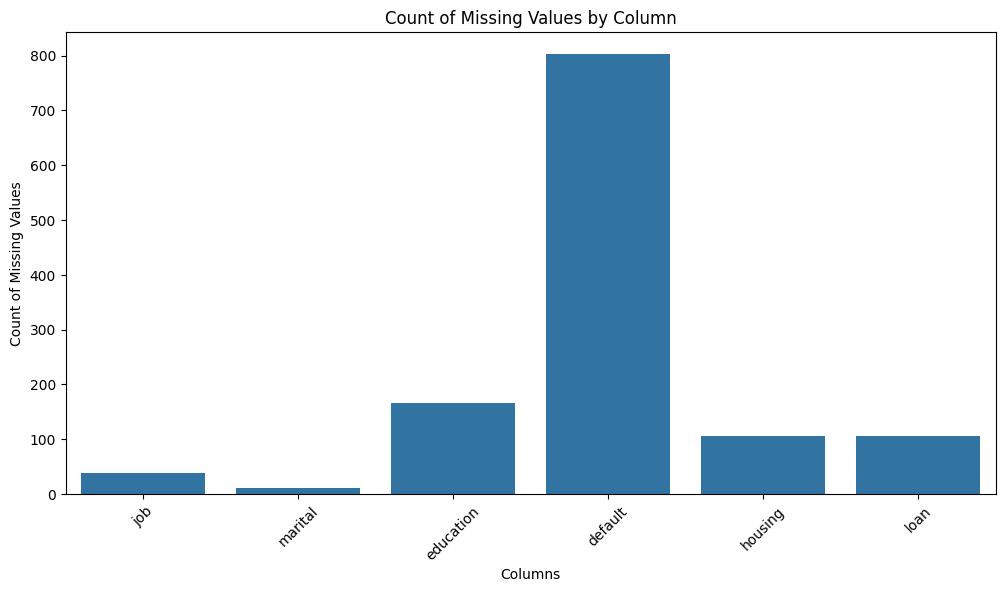

In [2]:
# Function to load data
def load_data(file_path):
    try:
        return pd.read_csv(file_path, sep=';')
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Function to check for missing values
def check_missing_values(data, missing_value='unknown'):
    missing_values = data.isin([missing_value]).sum()
    missing_values = missing_values[missing_values > 0]
    
    # Print formatted table
    table = [[col, val] for col, val in missing_values.items()]
    print("Missing Values:")
    print(tabulate(table, headers=["Column", "Missing Count"], tablefmt="pretty"))
    
    return data, missing_values

# Function to calculate percentage of missing values
def calculate_missing_percentage(data_missing):
    data, missing_values = data_missing
    missing_percentage = (missing_values / len(data)) * 100
    
    # Print formatted table
    table = [[col, f"{val:.2f}%"] for col, val in missing_percentage.items()]
    print("\nPercentage of Missing Values:")
    print(tabulate(table, headers=["Column", "Missing Percentage"], tablefmt="pretty"))
    
    return data, missing_values, missing_percentage

# Function to visualize missing values
def visualize_missing_values(data_missing_percentage):
    data, missing_values, missing_percentage = data_missing_percentage
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    plt.title('Count of Missing Values by Column')
    plt.ylabel('Count of Missing Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45)
    plt.show()
    return data

# Create pipeline
def create_pipeline(file_path, missing_value='unknown'):
    return Pipeline([
        ('load_data', FunctionTransformer(lambda _: load_data(file_path), validate=False)),
        ('check_missing_values', FunctionTransformer(lambda data: check_missing_values(data, missing_value), validate=False)),
        ('calculate_missing_percentage', FunctionTransformer(calculate_missing_percentage, validate=False)),
        ('visualize_missing_values', FunctionTransformer(visualize_missing_values, validate=False))
    ])

# Execute pipeline
file_path = 'dataset/bank-additional.csv'
pipeline = create_pipeline(file_path)
data = pipeline.fit_transform(None)

### Missing Value Analysis

Missing Values:
+-----------+---------------+
|  Column   | Missing Count |
+-----------+---------------+
|    job    |      39       |
|  marital  |      11       |
| education |      167      |
|  default  |      803      |
|  housing  |      105      |
|   loan    |      105      |
+-----------+---------------+
+-----------------------------------+--------+
|              Metric               | Value  |
+-----------------------------------+--------+
|              Column               |  job   |
|           Total Missing           |   39   |
|         Total Non-missing         |  4080  |
|   Proportion of 'yes' (Missing)   | 10.26% |
| Proportion of 'yes' (Non-missing) | 10.96% |
|     Difference in Proportion      | -0.70% |
+-----------------------------------+--------+

+-----------------------------------+---------+
|              Metric               |  Value  |
+-----------------------------------+---------+
|              Column               | marital |
|           Total Mis

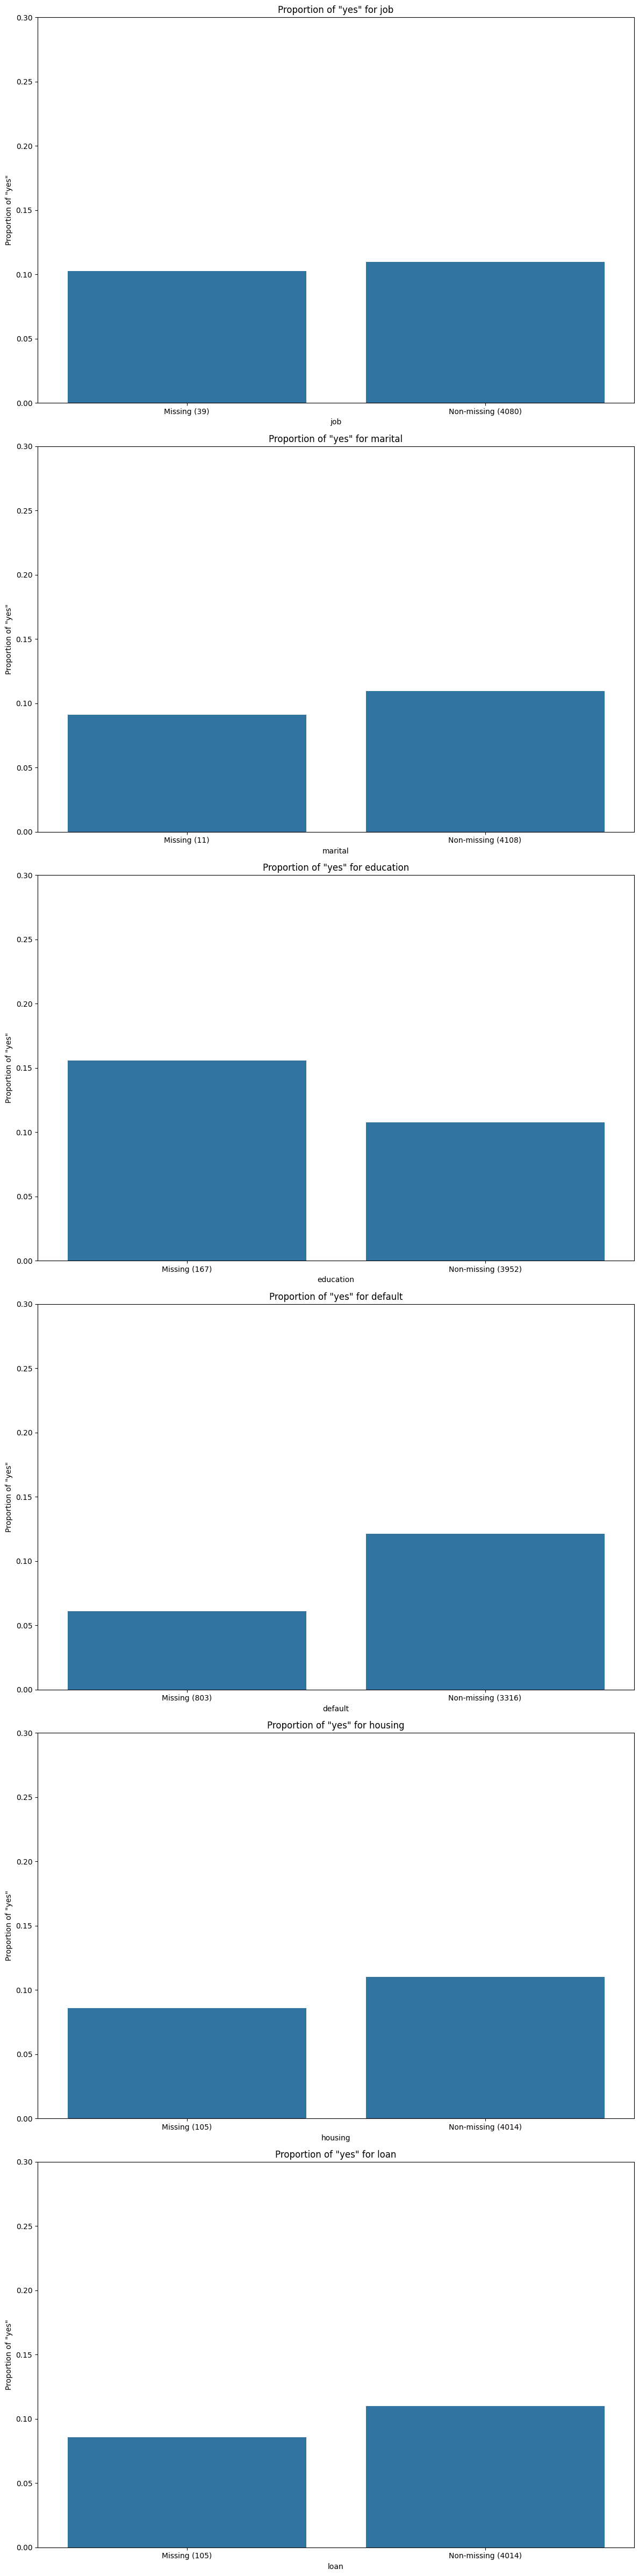

In [3]:

# Function to drop the 'duration' column because it is not known before a call is performed
def drop_duration(data):
    if 'duration' in data.columns:
        return data.drop('duration', axis=1)
    else:
        print("Warning: 'duration' column not found.")
        return data

# Function to convert 'yes'/'no' target to binary
def convert_target(data):
    if 'y' in data.columns:
        data['y'] = data['y'].map({'yes': 1, 'no': 0})
        return data
    else:
        print("Warning: 'y' column not found.")
        return data

# Function to analyze missing values' impact and visualize
def analyze_missing_values(data, missing_values, missing_value='unknown'):
    fig, axes = plt.subplots(nrows=len(missing_values.index), ncols=1, figsize=(12, 8 * len(missing_values.index)))
    for ax, col in zip(axes, missing_values.index):
        missing_mask = data[col] == missing_value
        total_missing = missing_mask.sum()
        total_non_missing = len(data) - total_missing
        proportion = data.groupby(missing_mask)['y'].mean()
        diff_percentage = (proportion[True] - proportion[False]) * 100
        
        # Print formatted table
        table = [
            ["Column", col],
            ["Total Missing", total_missing],
            ["Total Non-missing", total_non_missing],
            ["Proportion of 'yes' (Missing)", f"{proportion[True]:.2%}"],
            ["Proportion of 'yes' (Non-missing)", f"{proportion[False]:.2%}"],
            ["Difference in Proportion", f"{diff_percentage:.2f}%"]
        ]
        print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))
        print()
        
        # Visualization with seaborn
        sns.barplot(x=[f'Missing ({total_missing})', f'Non-missing ({total_non_missing})'], 
                    y=[proportion[True], proportion[False]], ax=ax)
        ax.set_title(f'Proportion of "yes" for {col}')
        ax.set_ylabel('Proportion of "yes"')
        ax.set_xlabel(col)
        ax.set_ylim(0, 0.3)
    plt.tight_layout()
    plt.show()
    return data

# Extract missing values
_, missing_values = check_missing_values(data)

# Create a pipeline
def create_pipeline(missing_values, missing_value='unknown'):
    return Pipeline([
        ('drop_duration', FunctionTransformer(drop_duration)),
        ('convert_target', FunctionTransformer(convert_target)),
        ('analyze_missing_values', FunctionTransformer(analyze_missing_values, kw_args={'missing_values': missing_values, 'missing_value': missing_value}))
    ])

# Execute pipeline
pipeline = create_pipeline(missing_values)
data = pipeline.fit_transform(data)


| **Column**   | **Missing Count** | **Difference in Proportion of 'Yes'** | **Decision**                                                                                                                                          |
|---------------|-------------------|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **job**       | 39               | -0.70%                                | The small difference suggests minimal bias. Imputed missing values with the mode (`most frequent value`).                                                  |
| **marital**   | 11               | -1.86%                                | The difference is small but notable. Imputed missing values with the mode, as the missing rate and impact are low.                                         |
| **education** | 167              | +4.81%                                | Missing values appear to show higher success rates. "unknown" will be encoded as a separate category to capture this distinction.                      |
| **default**   | 803              | -6.02%                                | The larger difference and high missing rate suggest that encoding "unknown" as a separate category might better capture its relationship to the target.   |
| **housing**   | 105              | -2.44%                                | The moderate difference suggests some potential bias. However after further testing with the full dataset (where the proportion is -%0.47), this bias appears to be a result of the random %10 selected more so than the actual impact of the class. Imputed missing values with the mode. |
| **loan**      | 105              | -2.44%                                | Similar situation to **housing** with a proportion of -%0.47, imputed with the mode. *The similarity with housing has been noted for future reference*|




# Final Encoding Decisions and Reasons

| **Variable**     | **Encoding Decision**     | **Reason**                                                                 |
|------------------|---------------------------|---------------------------------------------------------------------------|
| **job**          | One-hot encoding           | "job" is a nominal categorical variable with distinct types; one-hot encoding prevents introducing any ordinal relationships. |
| **marital**      | One-hot encoding           | "marital" is a categorical variable with distinct values and no natural order. One-hot encoding handles it appropriately. |
| **education**    | One-hot encoding           | "education" includes "unknown" as its own category; one-hot encoding treats each category (including `unknown`) as a separate binary column. |
| **default**      | One-hot encoding           | "default" is a binary categorical variable with "no" and "yes" values and additionally includes "unknown" as its own category, so one-hot encoding is appropriate. |
| **housing**      | One-hot encoding           | "housing" is a binary categorical variable with "no" and "yes" values, and one-hot encoding works well here. |
| **loan**         | One-hot encoding           | "loan" is also binary, with "no" and "yes" values, and one-hot encoding is suitable. |
| **contact**      | One-hot encoding           | "contact" is a nominal categorical variable with distinct types ("cellular", "telephone"), making one-hot encoding ideal. |
| **month**        | Cyclical encoding (sin/cos) | "month" is cyclical (e.g., December follows January), so sine and cosine transformations capture its cyclical nature. The complete lack of January and February, alongside the rarity of December has been noted.  |
| **day_of_week**  | One-hot encoding           | "day_of_week" is a nominal categorical variable with distinct values (days of the week) and no inherent order, so one-hot encoding is suitable. The lack of inherent order is due to the nature of this variable relating to many different weeks as opposed to a one week period. |
| **poutcome**     | One-hot encoding           | "poutcome" is categorical with distinct values (e.g., "failure", "success"), and one-hot encoding captures the separate categories. |



In [4]:
def encode_month_sin_cos(X):
    month_map = {'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    months = X["month"]  
    months = months.map(month_map).fillna(0)  
    month_sin = np.sin(2 * np.pi * months / 12)
    month_cos = np.cos(2 * np.pi * months / 12)
    return pd.DataFrame({"month_sin": month_sin, "month_cos": month_cos})

def month_feature_names_out(self, input_features): #this took way too long to figure out jesus christ
    return ["month_sin", "month_cos"]

In [5]:
categorical_impute_cols = ['job', 'marital', 'housing', 'loan']
categorical_pass_cols = ['education', 'default']

onehot_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 
               'day_of_week', 'poutcome', 'education']
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

mode_imputer = SimpleImputer(strategy='most_frequent', missing_values='unknown')
month_transformer = FunctionTransformer(encode_month_sin_cos, validate=False, feature_names_out=month_feature_names_out)
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

## Preprocessing and Imputation Pipeline

In [6]:
#Impute missing data
data[categorical_impute_cols] = mode_imputer.fit_transform(data[categorical_impute_cols])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('month_encoding', month_transformer, ['month']), 
        ('onehot', onehot_encoder, onehot_cols),
        ('scaling', scaler, numerical_cols)
    ],
    remainder='passthrough',  # Keeps other columns as is, keeping response variable, annoying cascading side effect, the y variable is renamed to remainder__y
)

transformed_data = preprocessor.fit_transform(data)
transformed_df = pd.DataFrame(transformed_data, columns=preprocessor.get_feature_names_out())


## Feature Engineering and Analysis

### Correlation Matrix

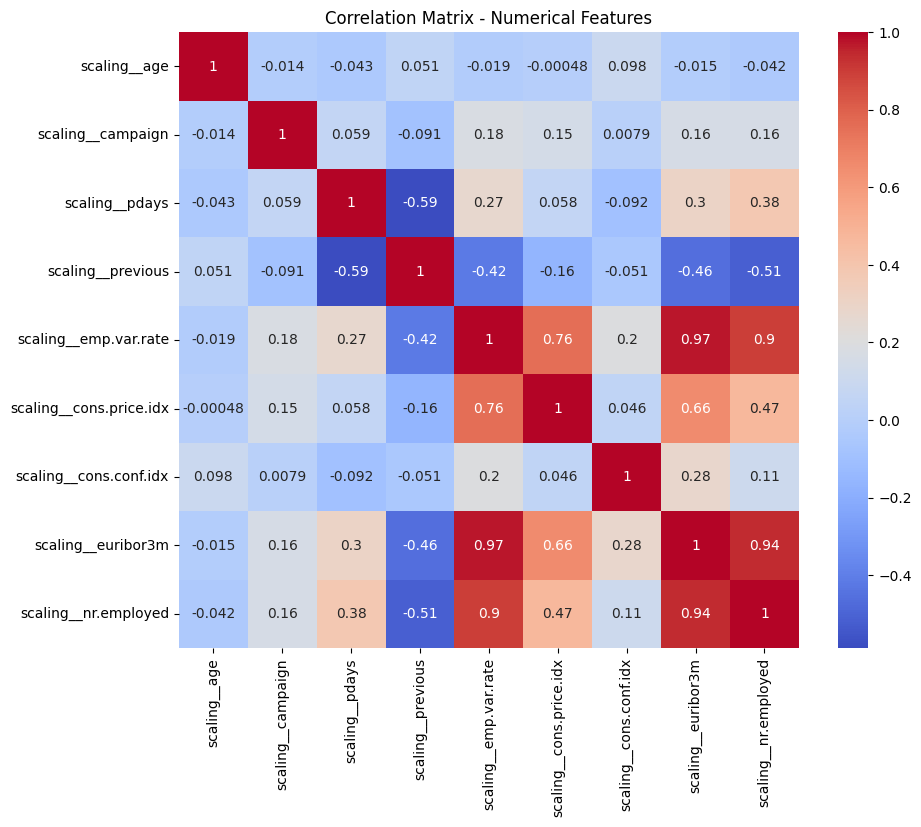

Correlations higher than 0.9:
+----+-----------------------+----------------------+--------------------+
|    |       Feature 1       |      Feature 2       |    Correlation     |
+----+-----------------------+----------------------+--------------------+
| 5  | scaling__emp.var.rate |  scaling__euribor3m  | 0.9703079598849326 |
| 6  | scaling__emp.var.rate | scaling__nr.employed | 0.8971732161536575 |
| 11 |  scaling__euribor3m   | scaling__nr.employed | 0.9425892832458503 |
+----+-----------------------+----------------------+--------------------+


In [11]:
# Column names with prefixes
numerical_cols_prefixed = [f'scaling__{col}' for col in numerical_cols]

# Calculate correlation matrix
numerical_corr = transformed_df[numerical_cols_prefixed].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix - Numerical Features")
plt.show()

# Find correlations higher than 0.9
high_corr = numerical_corr.where(numerical_corr > 0.8).stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Remove duplicate pairs
high_corr = high_corr[high_corr['Feature 1'] < high_corr['Feature 2']]

# Print formatted table
print("Correlations higher than 0.9:")
print(tabulate(high_corr, headers="keys", tablefmt="pretty"))

#Intended to drop highly correlated features for some reason it lowers the f1 score
#transformed_df = transformed_df.drop(columns=['scaling__euribor3m', 'scaling__emp.var.rate'])

### Correlation with Target and Variance Analysis

In [13]:
# Calculate the correlation
target_corr = transformed_df[numerical_cols_prefixed + ['remainder__y']].corr()['remainder__y'].drop('remainder__y')

# Convert to DataFrame for better formatting
target_corr_df = target_corr.sort_values(ascending=False).reset_index()
target_corr_df.columns = ['Feature', 'Correlation with y']

# Pretty print the DataFrame
print(tabulate(target_corr_df, headers='keys', tablefmt='pretty', showindex=False))

+-------------------------+----------------------+
|         Feature         |  Correlation with y  |
+-------------------------+----------------------+
|    scaling__previous    |  0.2556966295902877  |
|      scaling__age       | 0.06037408250697764  |
| scaling__cons.conf.idx  | 0.05439301829399102  |
|    scaling__campaign    | -0.07609088294850752 |
| scaling__cons.price.idx | -0.09832603241628207 |
|  scaling__emp.var.rate  | -0.28321567653282465 |
|   scaling__euribor3m    | -0.2985649713595483  |
|     scaling__pdays      | -0.3320115339486608  |
|  scaling__nr.employed   | -0.3492412340486672  |
+-------------------------+----------------------+


In [16]:
# Update onehot_cols with prefixed column names
onehot_cols_prefixed = [col for col in transformed_df.columns if col.startswith('onehot__')]

# Identify low variance columns
low_variance_cols = [col for col in onehot_cols_prefixed if transformed_df[col].var() < 0.01]

# Convert to DataFrame for better formatting
low_variance_df = pd.DataFrame(low_variance_cols, columns=['Low Variance Columns'])

# Print the DataFrame
print(tabulate(low_variance_df, headers='keys', tablefmt='pretty', showindex=False))

+------------------------------+
|     Low Variance Columns     |
+------------------------------+
|     onehot__default_yes      |
| onehot__education_illiterate |
+------------------------------+


In [ ]:
print("Correlation between one-hot encoded columns and target variable 'y':\n")

# Collect results in a list
results = []

for col in onehot_cols_prefixed:
    corr, p_value = pointbiserialr(transformed_df[col], transformed_df['remainder__y'])
    results.append([col, f"{corr:.4f}", f"{p_value:.4e}"])

# Convert results to DataFrame for better formatting
results_df = pd.DataFrame(results, columns=['Column', 'Correlation', 'P-value'])

# Pretty print the DataFrame
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

Correlation between one-hot encoded columns and target variable 'y':

+---------------------------------------+-------------+-------------+
|                Column                 | Correlation |   P-value   |
+---------------------------------------+-------------+-------------+
|          onehot__job_admin.           |   0.0391    | 1.2089e-02  |
|        onehot__job_blue-collar        |   -0.0678   | 1.3380e-05  |
|       onehot__job_entrepreneur        |   -0.0343   | 2.7825e-02  |
|         onehot__job_housemaid         |   -0.0050   | 7.4663e-01  |
|        onehot__job_management         |   -0.0158   | 3.1025e-01  |
|          onehot__job_retired          |   0.0784    | 4.7494e-07  |
|       onehot__job_self-employed       |   -0.0178   | 2.5351e-01  |
|         onehot__job_services          |   -0.0213   | 1.7265e-01  |
|          onehot__job_student          |   0.0558    | 3.4133e-04  |
|        onehot__job_technician         |   0.0090    | 5.6225e-01  |
|        onehot__job

## Model Training and Hyperparameter Tuning

In [20]:
# Data preparation
X = transformed_df.drop(columns=['remainder__y'])
y = transformed_df['remainder__y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Huge class imbalance, will utilize SMOTE and RandomUnderSampler to balance the classes to see if that helps

# Calculate value counts and normalize
value_counts = y_train.value_counts(normalize=True).reset_index()
value_counts.columns = ['Class', 'Proportion']

# Pretty print the DataFrame
print(tabulate(value_counts, headers='keys', tablefmt='pretty', showindex=False))

+-------+---------------------+
| Class |     Proportion      |
+-------+---------------------+
|  0.0  | 0.8904400606980273  |
|  1.0  | 0.10955993930197269 |
+-------+---------------------+


In [23]:
# Helper function for evaluation and visualization
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics in a table
    metrics_table = [
        ["Accuracy", f"{accuracy:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall", f"{recall:.4f}"],
        ["F1 Score", f"{f1:.4f}"]
    ]
    print(f"\n{name} Results:")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print("\nConfusion Matrix:")
    print(tabulate(cm_df, headers="keys", tablefmt="pretty"))

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve')
        plt.legend()
        plt.show()
    
    return f1

In [25]:
# Training strategies: Standard, Oversampling, Undersampling
sampling_strategies = {
    "Standard": None,
    "Oversampling (SMOTE)": SMOTE(random_state=42),
    "Undersampling": RandomUnderSampler(random_state=42)
}

# Hyperparameter grids
param_grids = {
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l2"],
        "classifier__solver": ["liblinear", "lbfgs"],
        "classifier__max_iter": [100, 200, 500]
    },
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 300, 500],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4]
    },
    "DecisionTreeClassifier": {
        "classifier__max_depth": [None, 10, 20, 30],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4]
    }
}

# Models to train
models = {
    "LogisticRegression": LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced'),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42, class_weight='balanced')
}


*** Training with Standard ***

Training LogisticRegression...
Best parameters for LogisticRegression:
+----------------------+-------+
|      Parameter       | Value |
+----------------------+-------+
|    classifier__C     |   1   |
| classifier__max_iter |  100  |
| classifier__penalty  |  l2   |
|  classifier__solver  | lbfgs |
+----------------------+-------+

LogisticRegression (Standard) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8119 |
| Precision | 0.3077 |
|  Recall   | 0.5778 |
| F1 Score  | 0.4015 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        617         |        117         |
| Actual Positive |         38         |         52         |
+-----------------+--------------------+--------------------+


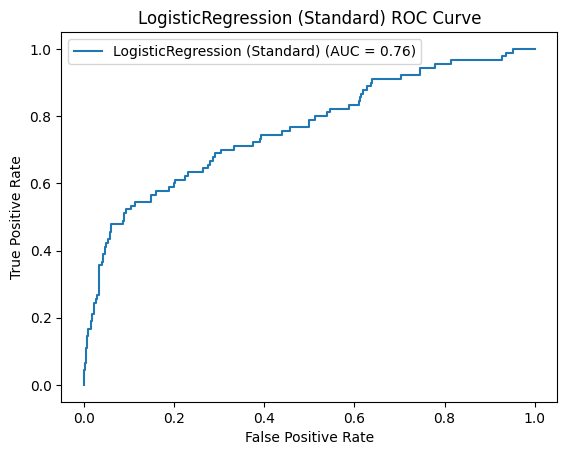


Training RandomForestClassifier...
Best parameters for RandomForestClassifier:
+-------------------------------+-------+
|           Parameter           | Value |
+-------------------------------+-------+
|     classifier__max_depth     |  10   |
| classifier__min_samples_leaf  |   4   |
| classifier__min_samples_split |   2   |
|   classifier__n_estimators    |  100  |
+-------------------------------+-------+

RandomForestClassifier (Standard) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8786 |
| Precision | 0.4468 |
|  Recall   | 0.4667 |
| F1 Score  | 0.4565 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        682         |         52         |
| Actual Positive |         48         |         42         |
+-----------------+--------

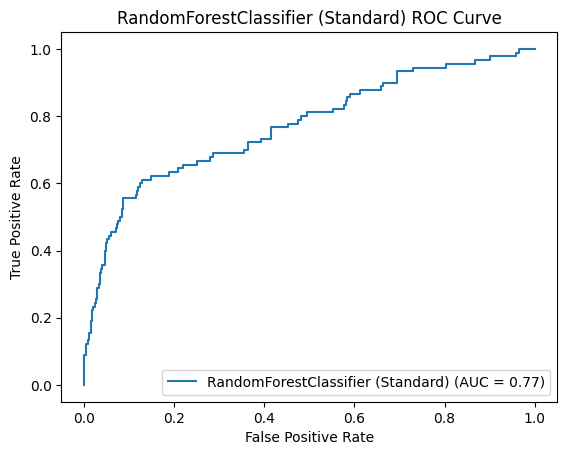


Training DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier:
+-------------------------------+-------+
|           Parameter           | Value |
+-------------------------------+-------+
|     classifier__max_depth     |  10   |
| classifier__min_samples_leaf  |   1   |
| classifier__min_samples_split |  10   |
+-------------------------------+-------+

DecisionTreeClassifier (Standard) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.7840 |
| Precision | 0.2317 |
|  Recall   | 0.4222 |
| F1 Score  | 0.2992 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        608         |        126         |
| Actual Positive |         52         |         38         |
+-----------------+--------------------+--------------------+


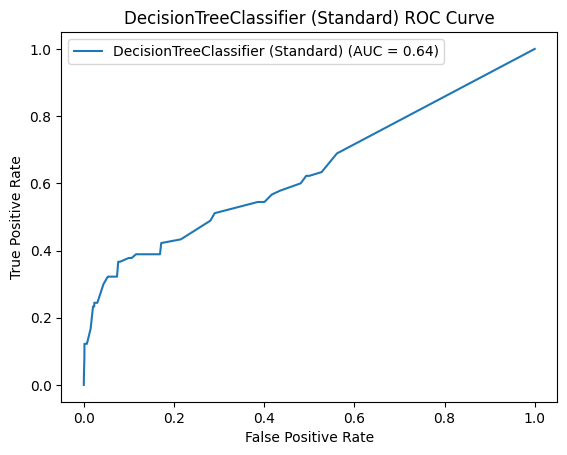


*** Training with Oversampling (SMOTE) ***

Training LogisticRegression...
Best parameters for LogisticRegression:
+----------------------+-------+
|      Parameter       | Value |
+----------------------+-------+
|    classifier__C     |  0.1  |
| classifier__max_iter |  100  |
| classifier__penalty  |  l2   |
|  classifier__solver  | lbfgs |
+----------------------+-------+

LogisticRegression (Oversampling (SMOTE)) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8010 |
| Precision | 0.2898 |
|  Recall   | 0.5667 |
| F1 Score  | 0.3835 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        609         |        125         |
| Actual Positive |         39         |         51         |
+-----------------+--------------------+---------------

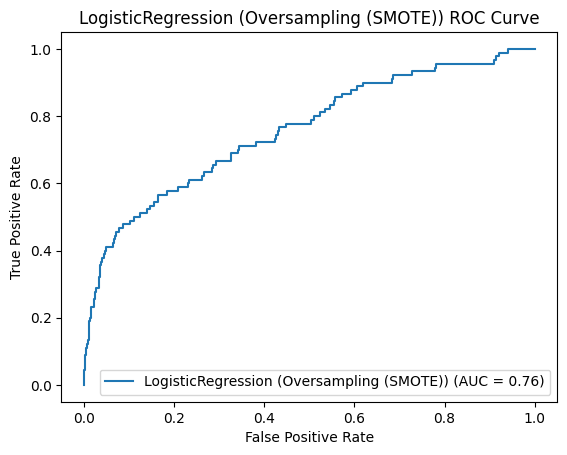


Training RandomForestClassifier...
Best parameters for RandomForestClassifier:
+-------------------------------+-------+
|           Parameter           | Value |
+-------------------------------+-------+
|     classifier__max_depth     |  10   |
| classifier__min_samples_leaf  |   4   |
| classifier__min_samples_split |   2   |
|   classifier__n_estimators    |  500  |
+-------------------------------+-------+

RandomForestClassifier (Oversampling (SMOTE)) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8871 |
| Precision | 0.4805 |
|  Recall   | 0.4111 |
| F1 Score  | 0.4431 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        694         |         40         |
| Actual Positive |         53         |         37         |
+--------------

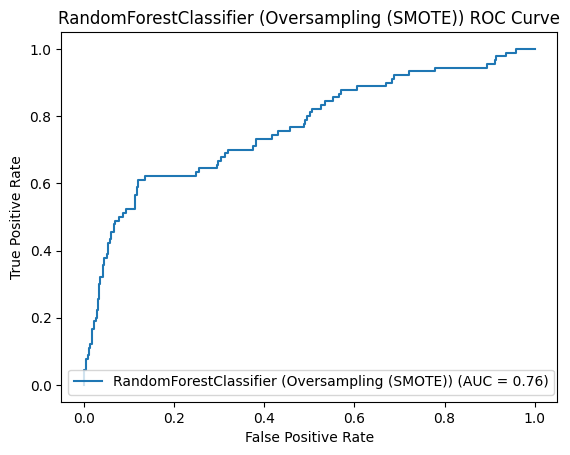


Training DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier:
+-------------------------------+-------+
|           Parameter           | Value |
+-------------------------------+-------+
|     classifier__max_depth     |  10   |
| classifier__min_samples_leaf  |   2   |
| classifier__min_samples_split |   2   |
+-------------------------------+-------+

DecisionTreeClassifier (Oversampling (SMOTE)) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8738 |
| Precision | 0.4125 |
|  Recall   | 0.3667 |
| F1 Score  | 0.3882 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        687         |         47         |
| Actual Positive |         57         |         33         |
+-----------------+--------------------+-----------------

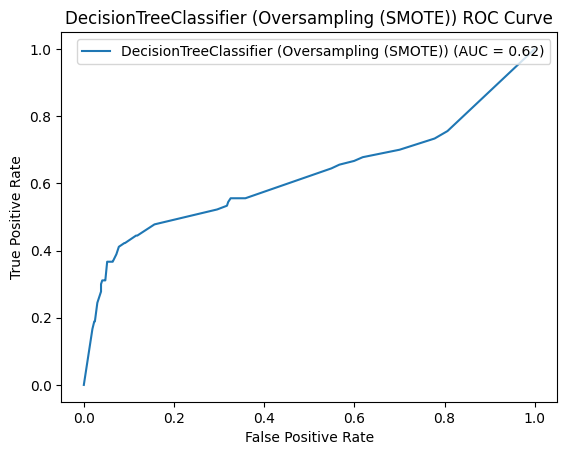


*** Training with Undersampling ***

Training LogisticRegression...
Best parameters for LogisticRegression:
+----------------------+-------+
|      Parameter       | Value |
+----------------------+-------+
|    classifier__C     |  0.1  |
| classifier__max_iter |  100  |
| classifier__penalty  |  l2   |
|  classifier__solver  | lbfgs |
+----------------------+-------+

LogisticRegression (Undersampling) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8046 |
| Precision | 0.2971 |
|  Recall   | 0.5778 |
| F1 Score  | 0.3925 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        611         |        123         |
| Actual Positive |         38         |         52         |
+-----------------+--------------------+--------------------+


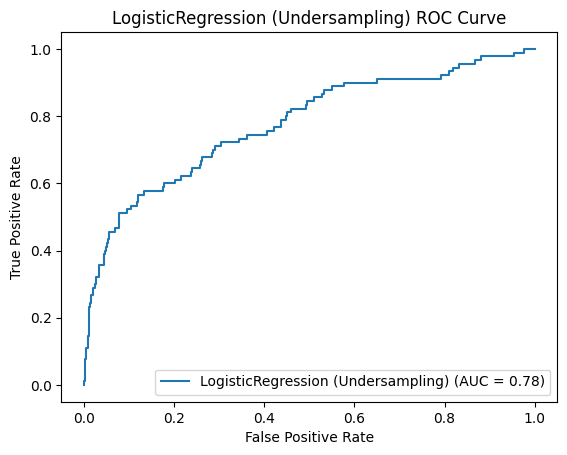


Training RandomForestClassifier...
Best parameters for RandomForestClassifier:
+-------------------------------+-------+
|           Parameter           | Value |
+-------------------------------+-------+
|     classifier__max_depth     |  10   |
| classifier__min_samples_leaf  |   2   |
| classifier__min_samples_split |  10   |
|   classifier__n_estimators    |  500  |
+-------------------------------+-------+

RandomForestClassifier (Undersampling) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.8471 |
| Precision | 0.3767 |
|  Recall   | 0.6111 |
| F1 Score  | 0.4661 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        643         |         91         |
| Actual Positive |         35         |         55         |
+-----------------+---

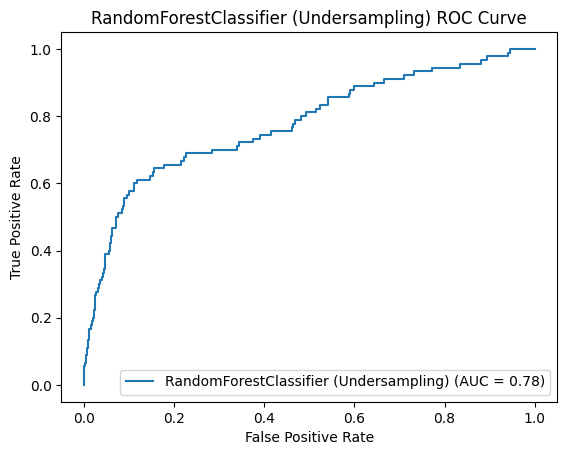


Training DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier:
+-------------------------------+-------+
|           Parameter           | Value |
+-------------------------------+-------+
|     classifier__max_depth     |  10   |
| classifier__min_samples_leaf  |   1   |
| classifier__min_samples_split |  10   |
+-------------------------------+-------+

DecisionTreeClassifier (Undersampling) Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.7354 |
| Precision | 0.2193 |
|  Recall   | 0.5556 |
| F1 Score  | 0.3145 |
+-----------+--------+

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |        556         |        178         |
| Actual Positive |         40         |         50         |
+-----------------+--------------------+--------------------+


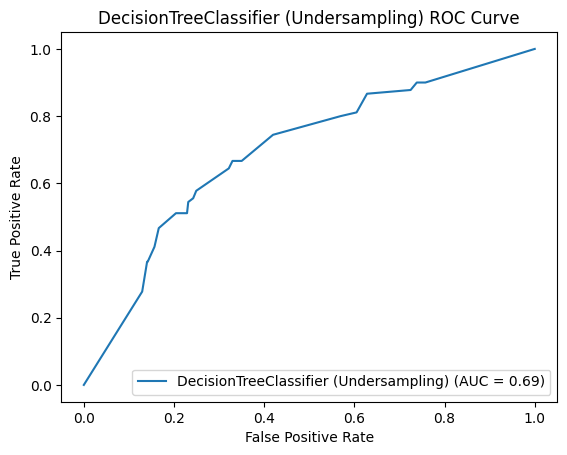


Best Model Information:
+---------------+------------------------+
|    Metric     |         Value          |
+---------------+------------------------+
|  Best Model   | RandomForestClassifier |
| Best Strategy |     Undersampling      |
| Best F1 Score |         0.4661         |
+---------------+------------------------+


In [28]:
# Best model tracking
best_model = None
best_f1_score = 0
best_model_name = ""
best_strategy = ""

# Train and evaluate for each sampling strategy and model
for strategy_name, sampler in sampling_strategies.items():
    print(f"\n*** Training with {strategy_name} ***")
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('sampler', sampler), 
            ('classifier', model)
        ])
        
        # Grid search for best hyperparameters
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Best model and parameters
        best_params = grid_search.best_params_
        best_pipeline = grid_search.best_estimator_
        
        # Print best parameters in a table
        best_params_table = [[param, value] for param, value in best_params.items()]
        print(f"Best parameters for {model_name}:")
        print(tabulate(best_params_table, headers=["Parameter", "Value"], tablefmt="pretty"))

        # Evaluate and visualize
        f1 = evaluate_model(best_pipeline, X_test, y_test, f"{model_name} ({strategy_name})")
        
        # Track best model
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model = best_pipeline
            best_model_name = model_name
            best_strategy = strategy_name

# Print best model information in a table
best_model_info = [
    ["Best Model", best_model_name],
    ["Best Strategy", best_strategy],
    ["Best F1 Score", f"{best_f1_score:.4f}"]
]
print("\nBest Model Information:")
print(tabulate(best_model_info, headers=["Metric", "Value"], tablefmt="pretty"))

In [29]:
joblib.dump(best_model, 'model.pkl')
joblib.dump(preprocessor, 'preprocessing_pipeline.pkl')

['preprocessing_pipeline.pkl']